In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# np.set_printoptions(precision=3, floatmode='fixed')

In [2]:
rng = np.random.RandomState(0)

n_samples, n_features = 50, 400
freqs = np.arange(n_features)
tt = np.zeros(6, 'i')
for j in range(6):
    tt[j] = (j+1) * n_features // 7
T = 8*np.random.random((n_samples,6))
print(tt)

[ 57 114 171 228 285 342]


In [3]:
X = np.zeros((n_samples, n_features))

for i in range(n_features):
    X[:, i] += T[:,0]*np.exp( -abs((freqs[i] - tt[0])**2 / 230)) + 0.05 * rng.normal(0, 1, n_samples)
    X[:, i] += T[:,1]*np.exp( -abs((freqs[i] - tt[1])**2 / 200)) + 0.05 * rng.normal(0, 1, n_samples)
    X[:, i] += T[:,2]*np.exp( -abs((freqs[i] - tt[2])**2 / 200)) + 0.05 * rng.normal(0, 1, n_samples)
    X[:, i] += T[:,3]*np.exp( -abs((freqs[i] - tt[3])**2 / 240)) + 0.05 * rng.normal(0, 1, n_samples)
    X[:, i] += T[:,4]*np.exp( -abs((freqs[i] - tt[4])**2 / 200)) + 0.05 * rng.normal(0, 1, n_samples)
    X[:, i] += T[:,5]*np.exp( -abs((freqs[i] - tt[5])**2 / 150)) + 0.05 * rng.normal(0, 1, n_samples)


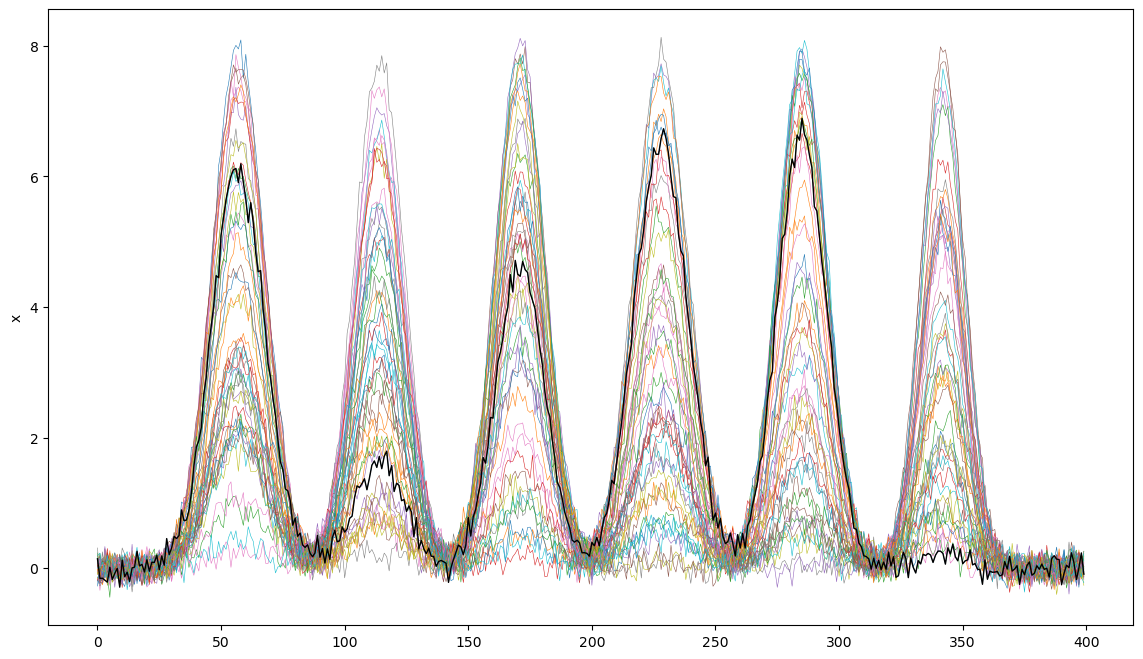

In [4]:
plt.figure(figsize=(14,8))
for k in range(n_samples):
    plt.plot(X[k], linewidth=0.4)
plt.plot(X[0], linewidth=1.0, color='k')
plt.ylabel('x')
plt.show()

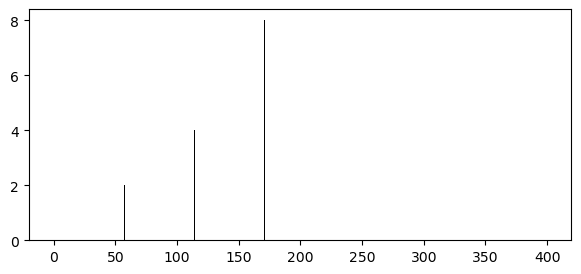

In [5]:
t1 = tt[0]
t2 = tt[1]
t3 = tt[2]
true_coef = np.zeros(n_features, 'd')
true_coef[t1] = 2  # информативные только первые десять коэффициентов
true_coef[t2] = 4  # информативные только первые десять коэффициентов
true_coef[t3] = 8  # информативные только первые десять коэффициентов

plt.figure(figsize=(7,3))
plt.bar(range(n_features), true_coef, color='k')
plt.show()

Y0 = np.dot(X, true_coef)

In [6]:
Y = Y0 #+ 5.0 * rng.normal(0, 1, n_samples)

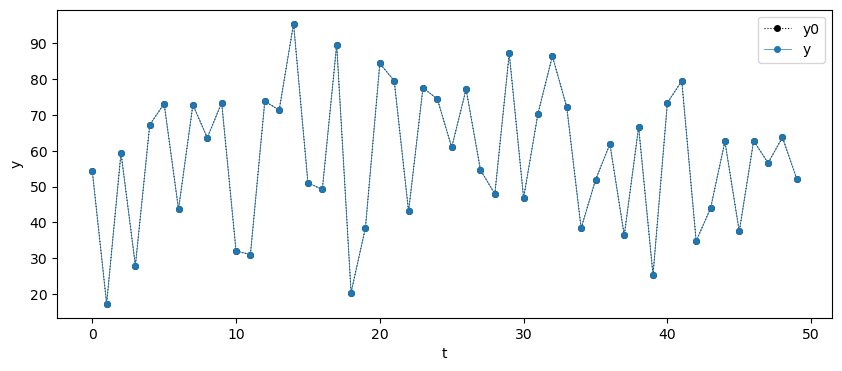

In [7]:
plt.figure(figsize=(10,4))
plt.plot(Y0, marker='o', markersize=4, color='k', linewidth=0.8, linestyle=':', label='y0')
plt.plot(Y, marker='o', markersize=4, linewidth=0.5, label='y')
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()

In [8]:
from sklearn.linear_model import Lasso, lars_path
from sklearn.metrics import r2_score

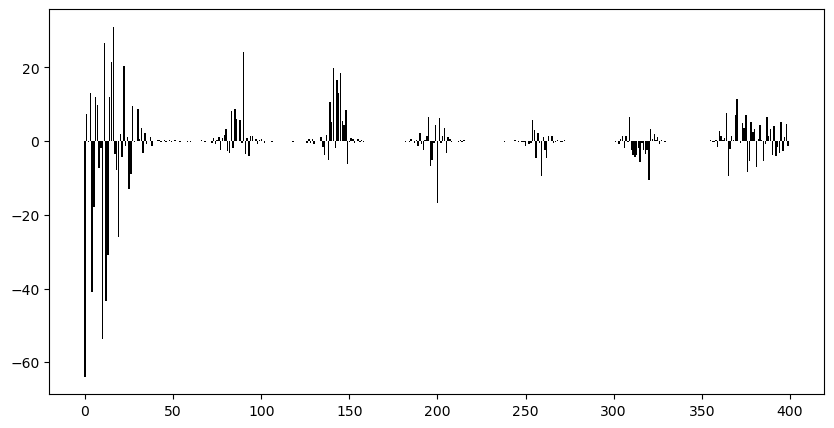

Lasso r^2: 1.000


In [9]:
lasso = Lasso(alpha=0.001, tol=0.01)
lasso.fit(X, Y)

plt.figure(figsize=(10,5))
plt.bar(range(n_features), lasso.coef_, color='k')
plt.show()

Y_p = lasso.predict(X)
r2 = r2_score(Y, Y_p)
print(f"Lasso r^2: {r2:.3f}")

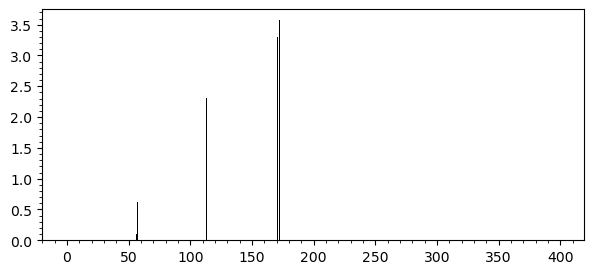

Lasso r^2: 0.946


In [10]:
lasso2 = Lasso(alpha=5.0, tol=0.001)
lasso2.fit(X, Y)

plt.figure(figsize=(7,3))
plt.bar(range(n_features), lasso2.coef_, color='k')
plt.minorticks_on()
plt.show()

Y2_p = lasso2.predict(X)
r2 = r2_score(Y, Y2_p)
print(f"Lasso r^2: {r2:.3f}")

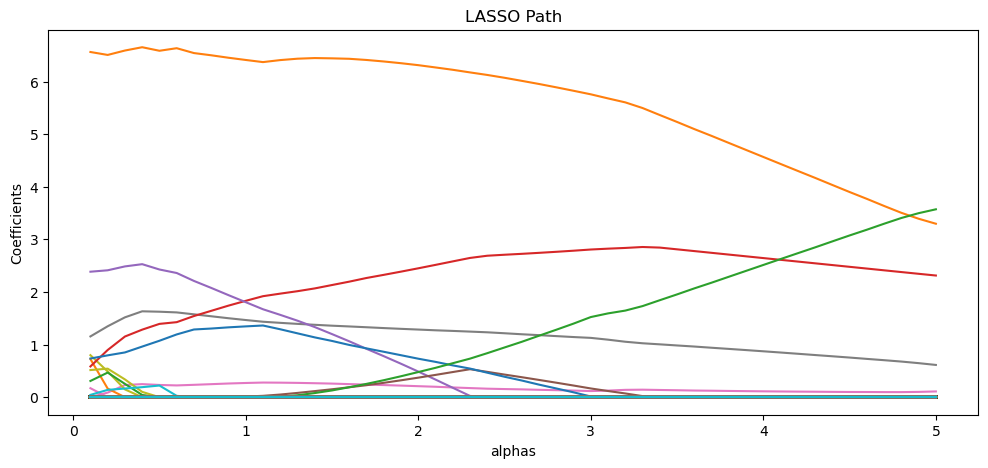

In [11]:
coef_path = []
alphas = np.linspace(0.1, 5., 50)
for alpha in alphas:
    lasso = Lasso(alpha=alpha, tol=0.001)
    lasso.fit(X, Y)
    coef_path.append(lasso.coef_)

coef_path = np.c_[tuple(coef_path)]

plt.figure(figsize=(12,5))
for j in range(n_features):
    plt.plot(alphas, coef_path[j,:])
plt.xlabel("alphas")
plt.ylabel("Coefficients")
plt.title("LASSO Path")

plt.show()

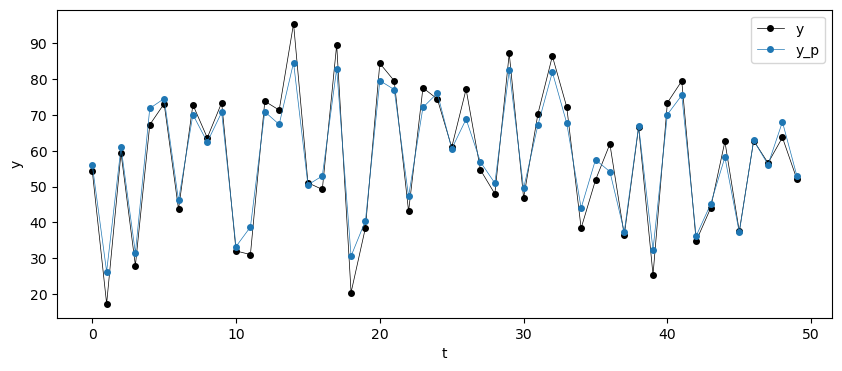

In [12]:
plt.figure(figsize=(10,4))
plt.plot(Y, marker='o', markersize=4, color='k', linewidth=0.5, label='y')
plt.plot(Y2_p, marker='o', markersize=4, linewidth=0.5, label='y_p')
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()

In [13]:
import mlgrad.models as models
import mlgrad.funcs as funcs
import mlgrad.funcs2 as funcs2
import mlgrad.avragg as avragg
import mlgrad.loss as loss
import mlgrad.regr as regr
import mlgrad.af as af
import mlgrad.gd as gd

In [42]:
# l1_reg = funcs2.SoftAbsoluteNorm(0.0001)
l1_reg = funcs2.AbsoluteNorm()
# l1_reg = funcs2.SquareNorm()

In [43]:
lm_ls = models.LinearModel(n_features)

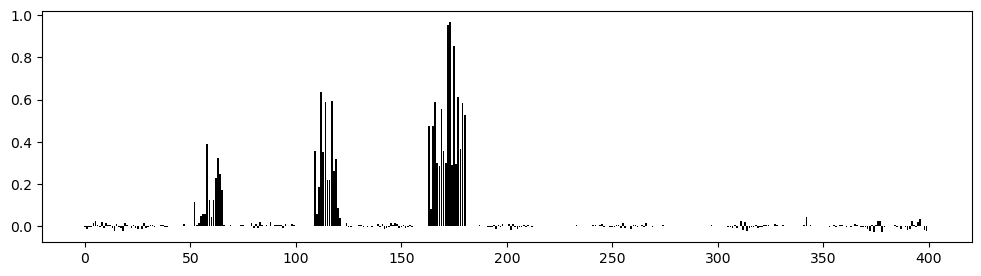

In [44]:
regr_ls = regr.regression(X, Y, lm_ls, regnorm=l1_reg, tau=5.0, h=0.1)

plt.figure(figsize=(12,3))
plt.bar(range(n_features+1), lm_ls.param, color='k')
plt.show()

In [64]:
lm_lsq = models.LinearModel(n_features)

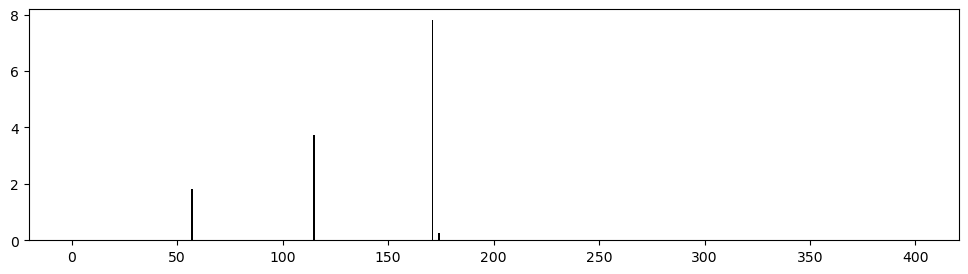

In [68]:
regr_lsq = regr.regression(X, Y, lm_lsq, regnorm=l1_reg, 
                          tau=7.0, h=0.1, n_iter=5000,
                          normalizer=gd.Masked(lm_lsq, 1.0e-2))

plt.figure(figsize=(12,3))
plt.bar(range(n_features+1), lm_lsq.param, color='k')
plt.show()

In [66]:
Y2_p0 = lm_ls.evaluate_all(X)
r2 = r2_score(Y, Y2_p0)
print(f"Lasso r^2: {r2:.3f}")

Lasso r^2: 0.993


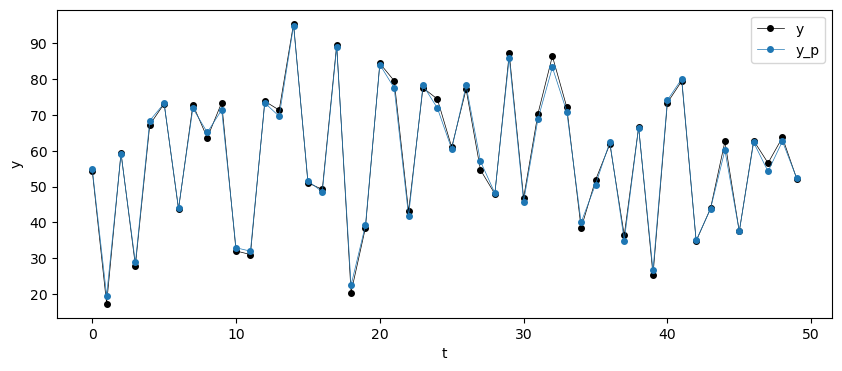

In [18]:
plt.figure(figsize=(10,4))
plt.plot(Y, marker='o', markersize=4, color='k', linewidth=0.5, label='y')
plt.plot(Y2_p0, marker='o', markersize=4, linewidth=0.5, label='y_p')
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()

In [19]:
n_out = int(0.2 * n_samples)
print(n_out)
Y_out = Y.copy()
for j in range(n_out):
    Y_out[j] = Y[j] + 30

10


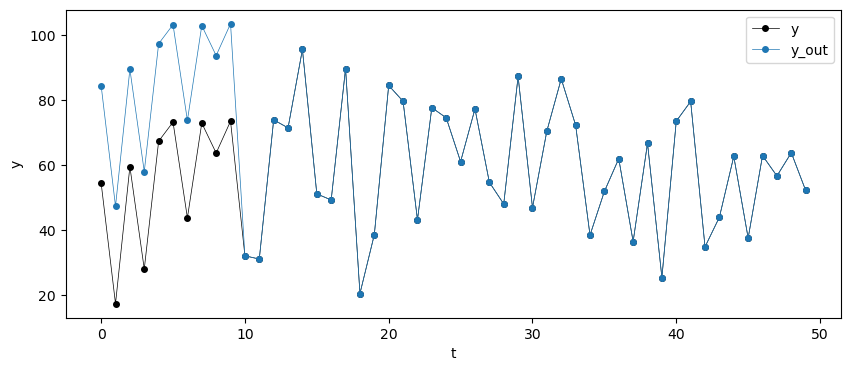

In [20]:
plt.figure(figsize=(10,4))
plt.plot(Y, marker='o', markersize=4, color='k', linewidth=0.5, label='y')
plt.plot(Y_out, marker='o', markersize=4, linewidth=0.5, label='y_out')
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()

In [73]:
lm_lsq2 = models.LinearModel(n_features)

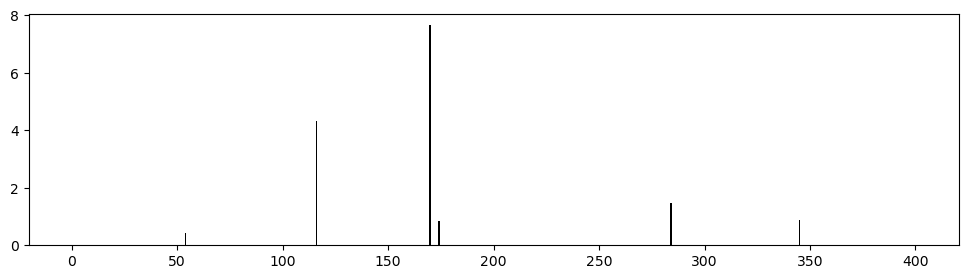

In [76]:
regr_lsq2 = regr.regression(X, Y_out, lm_lsq2, regnorm=l1_reg, 
                          tau=5.0, h=0.1, n_iter=5000,
                          normalizer=gd.Masked(lm_lsq2, 1.0e-2))

plt.figure(figsize=(12,3))
plt.bar(range(n_features+1), lm_lsq2.param, color='k')
plt.show()

In [23]:
Y2_p = lm_ls.evaluate_all(X)
r2 = r2_score(Y, Y2_p)
print(f"Lasso r^2: {r2:.3f}")

Lasso r^2: 0.832


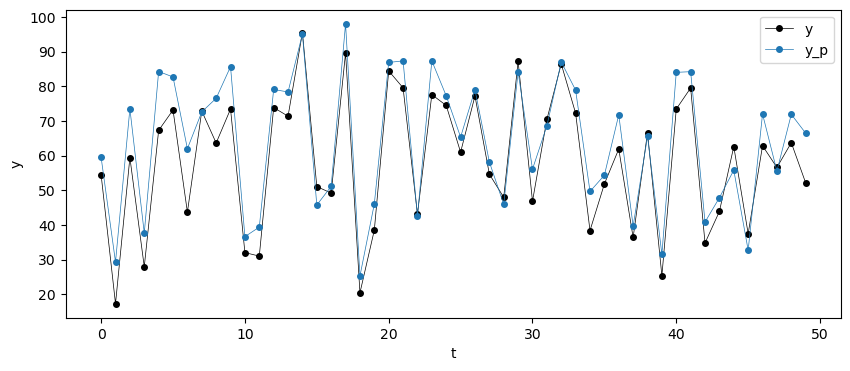

In [24]:
plt.figure(figsize=(10,4))
plt.plot(Y, marker='o', markersize=4, color='k', linewidth=0.5, label='y')
plt.plot(Y2_p, marker='o', markersize=4, linewidth=0.5, label='y_p')
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()

In [77]:
lm_wm = models.LinearModel(n_features)

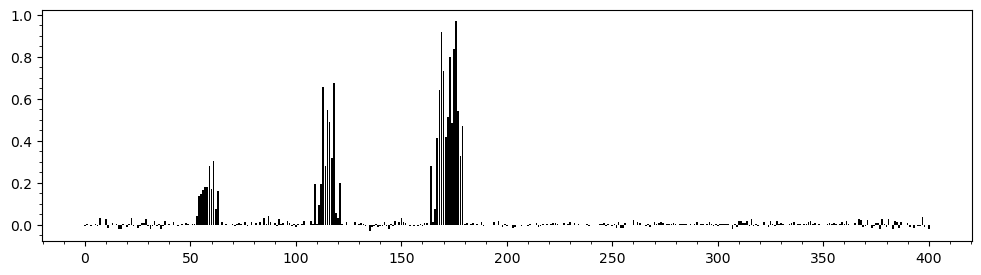

In [80]:
aggfunc = af.averaging_function("WM", funcs.quantile_func(0.79, funcs.Sqrt(0.001)))
regr_wm = regr.m_regression_irls(X, Y_out, lm_wm, agg_func=aggfunc, regnorm=l1_reg, 
                                 tau=5.0, h=0.1, n_iter=5000)

plt.figure(figsize=(12,3))

plt.bar(range(n_features+1), lm_wm.param, color='k')
plt.minorticks_on()
plt.show()

In [27]:
Y2_p_out = lm_wm.evaluate_all(X)
r2_out = r2_score(Y, Y2_p_out)
print(f"Lasso r^2: {r2_out:.3f}")

Lasso r^2: 0.996


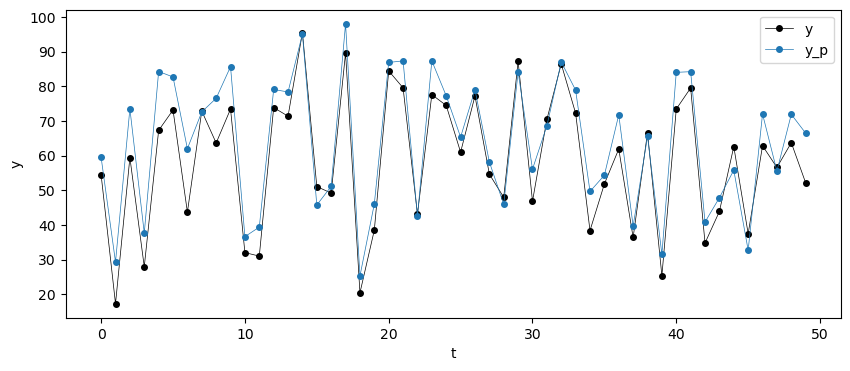

In [28]:
plt.figure(figsize=(10,4))
plt.plot(Y, marker='o', markersize=4, color='k', linewidth=0.5, label='y')
plt.plot(Y2_p, marker='o', markersize=4, linewidth=0.5, label='y_p')
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()

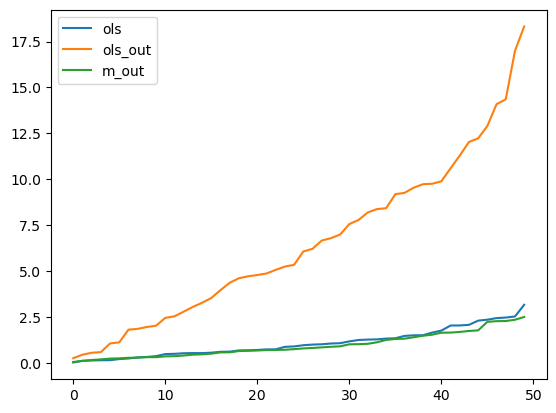

In [29]:
plt.plot(sorted(np.abs(Y2_p0-Y)), label='ols')
plt.plot(sorted(np.abs(Y2_p-Y)), label='ols_out')
plt.plot(sorted(np.abs(Y2_p_out-Y)), label='m_out')
plt.legend()
plt.show()

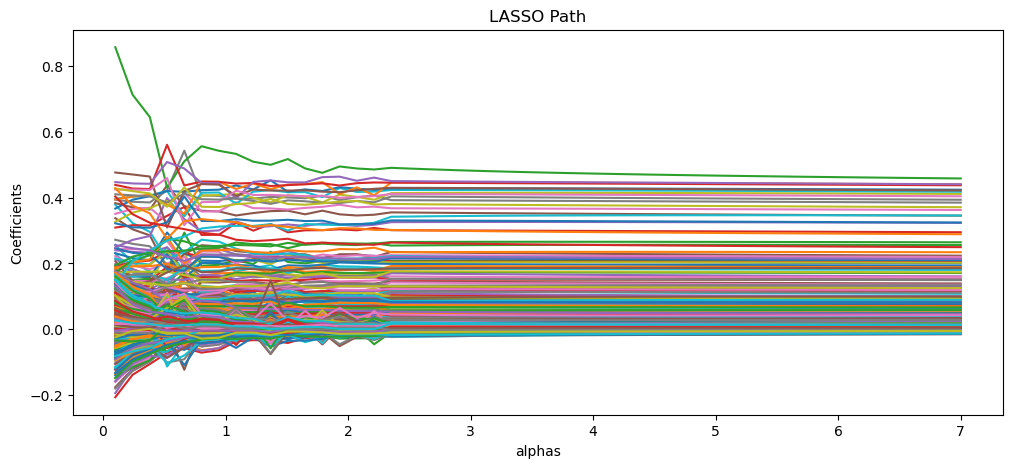

In [30]:
coef_path = []
alphas = np.linspace(0.1, 7., 50)
for alpha in alphas:
    lm_wm = models.LinearModel(n_features)
    regr_wm = regr.m_regression_irls(X, Y_out, lm_wm, agg_func=aggfunc, regnorm=l1_reg, tau=alpha)
    coef_path.append(np.asarray(lm_wm.param))

coef_path = np.c_[tuple(coef_path)]

plt.figure(figsize=(12,5))
for j in range(n_features):
    plt.plot(alphas, coef_path[j,:])
plt.xlabel("alphas")
plt.ylabel("Coefficients")
plt.title("LASSO Path")

plt.show()